In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random

# Paths
input_dir = r"D:\\Capstone Project\\Leaf_coffe_dataset"  # Original dataset
output_dir = r"D:\\Capstone Project\\Leaf_coffe_augmented"  # Augmented dataset
os.makedirs(output_dir, exist_ok=True)

# Target number of images per class
TARGET_IMAGES = 30000

# --- ✅ FIXED AUGMENTATION FUNCTIONS ---

def augment_brightness(image):
    """Randomly adjust brightness within a safe range."""
    image = tf.image.adjust_brightness(image, delta=random.uniform(-0.4, 0.4)).numpy()
    return np.clip(image, 0, 1)

def augment_contrast(image):
    """Randomly adjust contrast within a safe range."""
    image = tf.image.adjust_contrast(image, contrast_factor=random.uniform(0.9, 1.2)).numpy()
    return np.clip(image, 0, 1)

def augment_flip(image):
    """Horizontally flip image."""
    return np.flip(image, axis=1)  # NumPy equivalent of tf.image.flip_left_right

def augment_rotate(image):
    """Rotate image without restrictions."""
    h, w, _ = image.shape
    angle = np.random.uniform(-30, 30)  # More aggressive rotation
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    
    return cv2.warpAffine(image, M, (w, h))

def augment_shift(image):
    """Apply unrestricted translation shift."""
    h, w, _ = image.shape
    w_shift = np.random.uniform(-0.2, 0.2) * w  # Increased shift range
    h_shift = np.random.uniform(-0.2, 0.2) * h
    M_shift = np.float32([[1, 0, w_shift], [0, 1, h_shift]])

    return cv2.warpAffine(image, M_shift, (w, h))

def augment_zoom(image):
    """Apply more aggressive zoom."""
    zoom_factor = np.random.uniform(0.8, 1.2)  # Increased zoom range
    new_size = int(224 * zoom_factor)
    zoomed = cv2.resize(image, (new_size, new_size))

    return cv2.resize(zoomed, (224, 224))

def augment_cover_part(image):
    """Randomly covers a part of the image with a black square."""
    h, w, _ = image.shape
    mask_size = random.randint(int(h * 0.3), int(h * 0.3))  # Reduced mask size

    x = random.randint(0, w - mask_size)
    y = random.randint(0, h - mask_size)

    image[y:y+mask_size, x:x+mask_size, :] = 0  # Black patch
    return image

def augment_gaussian_noise(image):
    """Add light Gaussian noise safely."""
    mean, stddev = 0, random.uniform(10, 30)  
    noise = np.random.normal(mean, stddev, image.shape).astype(np.float32) / 255.0

    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

def augment_salt_pepper_noise(image, salt_prob=0.2, pepper_prob=0.2):
    """Apply low-intensity salt & pepper noise."""
    noisy_image = image.copy()
    h, w, c = image.shape

    num_salt = int(salt_prob * h * w)
    num_pepper = int(pepper_prob * h * w)

    salt_coords = [np.random.randint(0, i, num_salt) for i in [h, w]]
    pepper_coords = [np.random.randint(0, i, num_pepper) for i in [h, w]]

    noisy_image[salt_coords[0], salt_coords[1], :] = 1.0  # White spots
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0.0  # Black spots

    return noisy_image

# List of augmentations
AUGMENTATIONS = [
    augment_brightness, augment_contrast, augment_flip,
    augment_rotate, augment_shift, augment_zoom,
    augment_cover_part, augment_gaussian_noise, augment_salt_pepper_noise
]

# --- ✅ PROCESSING DATASET ---
for class_name in os.listdir(input_dir):
    class_input_path = os.path.join(input_dir, class_name)
    class_output_path = os.path.join(output_dir, class_name)
    os.makedirs(class_output_path, exist_ok=True)

    print(f"Processing class '{class_name}'...")

    images = os.listdir(class_input_path)
    num_original = len(images)

    if num_original == 0:
        print(f"⚠️ Skipping '{class_name}' (no images found).")
        continue

    print(f"🔹 Found {num_original} original images.")

    # Copy original images
    for image_name in images:
        image_path = os.path.join(class_input_path, image_name)
        image = cv2.imread(image_path)
        if image is None:
            continue  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        image = cv2.resize(image, (224, 224))  

        # Save original image
        save_path = os.path.join(class_output_path, f"orig_{image_name}")
        cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    num_needed = TARGET_IMAGES - num_original
    print(f"🔹 Generating {num_needed} augmented images.")

    aug_count = 0
    while aug_count < num_needed:
        for image_name in images:
            image_path = os.path.join(class_input_path, image_name)
            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Apply 1-3 random augmentations safely
            num_augmentations = random.randint(1, 3)
            chosen_augmentations = random.sample(AUGMENTATIONS, num_augmentations)

            aug_image = image.astype(np.float32) / 255.0  # Normalize before augmentation
            for aug_func in chosen_augmentations:
                aug_image = aug_func(aug_image)

            aug_image = (aug_image * 255).astype(np.uint8)  # Convert back to [0,255]

            save_path = os.path.join(class_output_path, f"aug_{aug_count}_{image_name}")
            cv2.imwrite(save_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

            aug_count += 1
            if aug_count >= num_needed:
                break  

    print(f"✅ Class '{class_name}' now contains 30,000 images.")

print("🎉 Data augmentation complete!")


Processing class 'Cerscospora'...
🔹 Found 7681 original images.
🔹 Generating 22319 augmented images.
✅ Class 'Cerscospora' now contains 30,000 images.
Processing class 'Healthy'...
🔹 Found 18984 original images.
🔹 Generating 11016 augmented images.
✅ Class 'Healthy' now contains 30,000 images.
Processing class 'Leaf rust'...
🔹 Found 8336 original images.
🔹 Generating 21664 augmented images.
✅ Class 'Leaf rust' now contains 30,000 images.
Processing class 'Miner'...
🔹 Found 16978 original images.
🔹 Generating 13022 augmented images.
✅ Class 'Miner' now contains 30,000 images.
Processing class 'Phoma'...
🔹 Found 6571 original images.
🔹 Generating 23429 augmented images.
✅ Class 'Phoma' now contains 30,000 images.
🎉 Data augmentation complete!


📂 Class: Cerscospora (Augmented Samples)


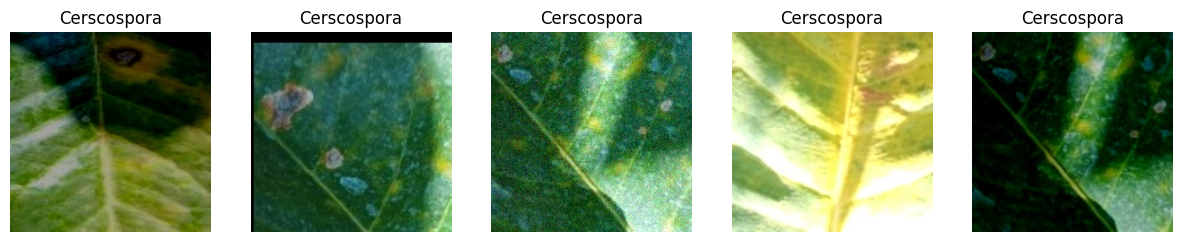

📂 Class: Healthy (Augmented Samples)


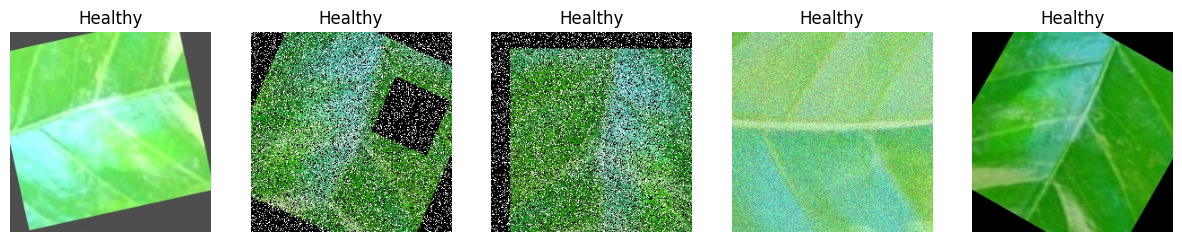

📂 Class: Leaf rust (Augmented Samples)


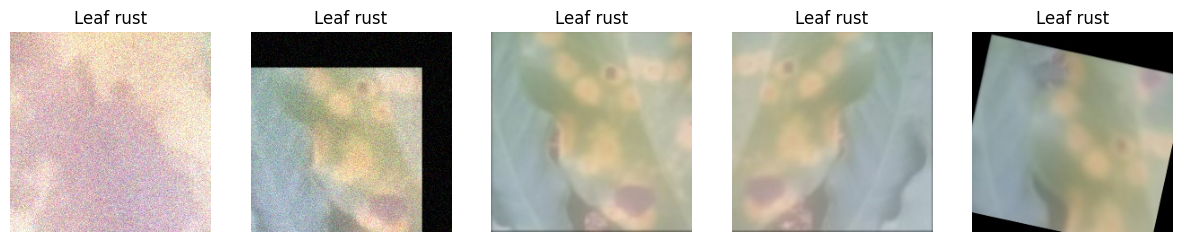

📂 Class: Miner (Augmented Samples)


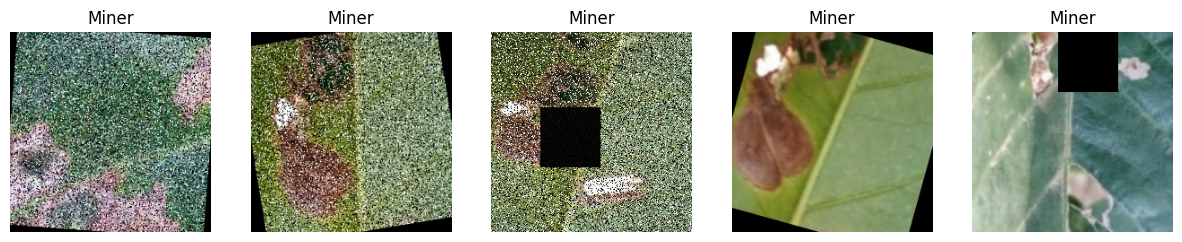

📂 Class: Phoma (Augmented Samples)


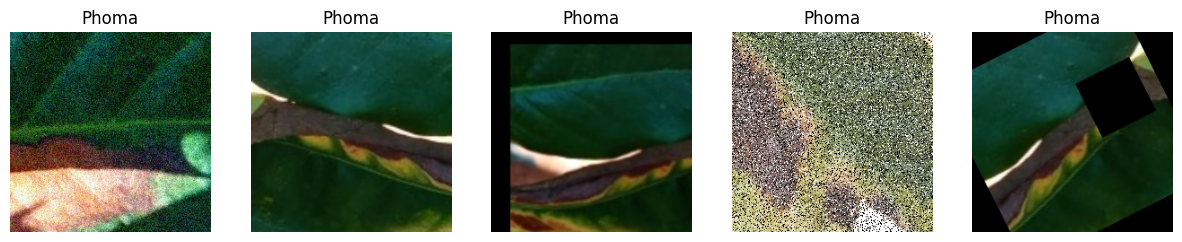

In [15]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to augmented dataset
dataset_dir_augmented = r"D:\\Capstone Project\\Leaf_coffe_augmented" 

# Get class names
classes = os.listdir(dataset_dir_augmented)

for cls in classes:
    class_path = os.path.join(dataset_dir_augmented, cls)

    # Ensure the class folder contains images and filter only augmented images
    sample_images = [img for img in os.listdir(class_path) if img.startswith('aug_') and img.endswith(('.png', '.jpg', '.jpeg'))][:5]

    if not sample_images:
        print(f"⚠️ No augmented images found for class: {cls}")
        continue

    print(f"📂 Class: {cls} (Augmented Samples)")
    plt.figure(figsize=(15, 5))

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)  # Read image
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

    plt.show()
